In [ ]:
!wget https://ai-data.obs.ru-moscow-1.hc.sbercloud.ru/МО_на_графах.zip

In [ ]:
!unzip МО_на_графах.zip

Archive:  МО_на_графах.zip
  inflating: ВК/hackathon_mos_sep2022.zip  
error: invalid zip file with overlapped components (possible zip bomb)


In [ ]:
%cd ВК
!unzip hackathon_mos_sep2022.zip

/content/ВК
Archive:  hackathon_mos_sep2022.zip
 extracting: FINAL_ALL_SEQUENCES_TRAINTEST.tsv.zip  
 extracting: FINAL_FEATURES_FRIENDS.tsv.zip  
 extracting: FINAL_FEATURES_TRAINTEST.tsv.zip  
 extracting: FINAL_SEQUENCES_MATRIX.tsv.zip  
 extracting: FINAL_TARGETS_DATES_TRAINTEST.tsv.zip  


In [ ]:
!unzip FINAL_FEATURES_TRAINTEST.tsv.zip
!unzip FINAL_TARGETS_DATES_TRAINTEST.tsv.zip

Archive:  FINAL_FEATURES_TRAINTEST.tsv.zip
  inflating: FINAL_FEATURES_TRAINTEST.tsv  
  inflating: __MACOSX/._FINAL_FEATURES_TRAINTEST.tsv  


In [ ]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import time
from IPython.display import clear_output
from tqdm.notebook import tqdm
from collections import defaultdict

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

sns.set(font_scale=1.3)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
targets = pd.read_csv('./ВК/FINAL_TARGETS_DATES_TRAINTEST.tsv', sep='\t')
features = pd.read_csv('./ВК/FINAL_FEATURES_TRAINTEST.tsv', sep='\t')

data = targets.merge(features, how='inner', on='CLIENT_ID')
data = data[data['TARGET'] != 'test']
data = data.drop(columns=['RETRO_DT', 'CLIENT_ID'])

In [ ]:
data

,TARGET,i1047,i1048,i1056,i1058,i1059,i1060,i1065,i1066,i1067,...,u8=17,u8=18,u8=19,u8=2,u8=20,u8=21,u8=6,u8=7,u8=8,u8=9
0,0,0.0,0.0,304.0,0.0,0.0,28.0,165.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,3.0,157.0,0.0,0.0,0.0,92.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0.0,250.0,314.0,3.0,12.0,525.0,107.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0.0,4.0,17.0,0.0,3.0,3.0,10.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1,0.0,0.0,255.0,0.0,17.0,0.0,168.0,0.0,21.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159281,0,0.0,47.0,43.0,0.0,2.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
159283,0,0.0,0.0,24.0,0.0,0.0,0.0,12.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,65.0,0.0,0.0,0.0,0.0
159284,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
159285,0,0.0,1.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
import pickle

with open('./important_feat.pickle', 'rb') as f:
    important_feat = pickle.load(f)

In [ ]:
class Features(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
      X = torch.tensor(self.X[idx]).float()
      y = torch.tensor(self.y[idx]).float()
      return X, y

In [ ]:
from sklearn.preprocessing import StandardScaler


X, y = data[important_feat].values, data['TARGET'].values.astype(int)
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, stratify=y, test_size=0.2)
ss = StandardScaler().fit(X_train)
X_train = ss.transform(X_train)
X_val = ss.transform(X_val)

In [ ]:
train_features = Features(X_train, y_train)
train_dataloader = DataLoader(train_features, shuffle=True, batch_size=2048)

val_features = Features(X_val, y_val)
val_dataloader = DataLoader(val_features, shuffle=False, batch_size=2048)

In [ ]:
model = Model().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

n_epochs = 20
n = 128

epoch: 20
time per epoch: 13.842376470565796
val score: 0.5734455246647036
val loss: 0.596665464914762


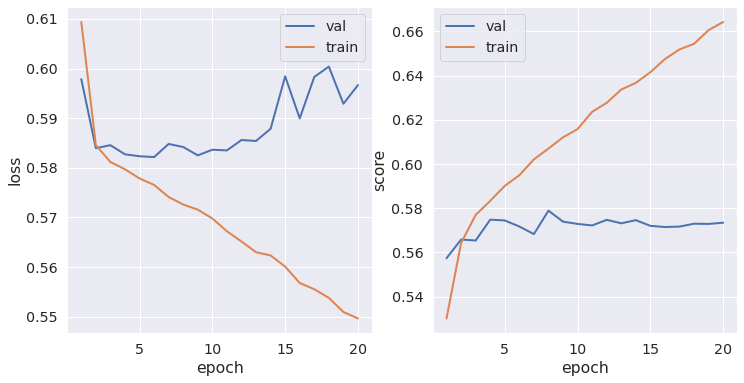

In [ ]:
history = defaultdict(list)
for epoch in range(n_epochs):
    train_score = []
    train_loss = []
    start = time.time()
    model.train()
    for X, y in tqdm(train_dataloader):
        optimizer.zero_grad()
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()

        train_score.append(roc_auc_score(y.cpu().numpy(), pred.detach().cpu().numpy()))
        train_loss.append(loss.item())

    history['train_loss'].append(np.mean(train_loss))
    history['train_score'].append(np.mean(train_score))

    val_score = []
    val_loss = []
    model.eval()
    for X, y in tqdm(val_dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = criterion(pred, y)

        val_score.append(roc_auc_score(y.cpu().numpy(), pred.detach().cpu().numpy()))
        val_loss.append(loss.item())

    history['val_loss'].append(np.mean(val_loss))
    history['val_score'].append(np.mean(val_score))

    clear_output()
    print('epoch: {}'.format(epoch + 1))
    print('time per epoch: {}'.format(time.time() - start))
    print('val score: {}'.format(history['val_score'][-1]))
    print('val loss: {}'.format(history['val_loss'][-1]))

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(np.arange(epoch + 1) + 1, history['val_loss'], lw=2, label='val')
    plt.plot(np.arange(epoch + 1) + 1, history['train_loss'], lw=2, label='train')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(np.arange(epoch + 1) + 1, history['val_score'], lw=2, label='val')
    plt.plot(np.arange(epoch + 1) + 1, history['train_score'], lw=2, label='train')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.legend()

    plt.show()

In [ ]:
y_true = []
y_pred = []
model.eval()
for X, y in tqdm(val_dataloader):
    X, y = X.to(device), y.to(device)
    pred = model(X)
    loss = criterion(pred, y)

    y_true.extend(y.cpu().numpy())
    y_pred.extend(pred.detach().cpu().numpy())

  0%|          | 0/13 [00:00<?, ?it/s]

In [ ]:
roc_auc_score(y_true, y_pred)

0.5601222231794362